# Investigating_Multilingual_NMT_Representations_at_Scale for BLOOM and languages English and Marathi respectively

### Installs

In [2]:
!pip install datasets bitsandbytes transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Imports

In [3]:
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import sklearn
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from scipy.linalg import svd
from sklearn.cross_decomposition import CCA

### Dataset

In [4]:
ds = load_dataset("Aryan2406/english-marathi",split="train[20:200]")
print(ds)
iterable_ds=ds.to_iterable_dataset()
print(next(iter(iterable_ds)))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

train_dataset_new.csv:   0%|          | 0.00/3.57M [00:00<?, ?B/s]

validation_dataset.csv:   0%|          | 0.00/453k [00:00<?, ?B/s]

test_dataset_new.csv:   0%|          | 0.00/447k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/37595 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4699 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4700 [00:00<?, ? examples/s]

Dataset({
    features: ['eng', 'mar'],
    num_rows: 180
})
{'eng': 'i still read every day', 'mar': 'मी अजूनही दररोज वाचते'}


### Tokenizer and Model

In [5]:
quantization_config=BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16, #4-bit Normalized Float
     bnb_4bit_use_double_quant=True # nested quantization
)

device="cuda" if torch.cuda.is_available() else "cpu"

bloom_tokenizer=AutoTokenizer.from_pretrained("bigscience/bloom-7b1")
bloom_model=AutoModelForCausalLM.from_pretrained(
    "bigscience/bloom-7b1",
    quantization_config=quantization_config,
    trust_remote_code=True
).to(device)

bloom_model


tokenizer_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/739 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/28.9k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.16G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

BloomForCausalLM(
  (transformer): BloomModel(
    (word_embeddings): Embedding(250880, 4096)
    (word_embeddings_layernorm): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
    (h): ModuleList(
      (0-29): 30 x BloomBlock(
        (input_layernorm): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (self_attention): BloomAttention(
          (query_key_value): Linear4bit(in_features=4096, out_features=12288, bias=True)
          (dense): Linear4bit(in_features=4096, out_features=4096, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (post_attention_layernorm): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (mlp): BloomMLP(
          (dense_h_to_4h): Linear4bit(in_features=4096, out_features=16384, bias=True)
          (gelu_impl): BloomGelu()
          (dense_4h_to_h): Linear4bit(in_features=16384, out_features=4096, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((4096,), eps=1e-05, elementwise_a

### Extract representations

#### For one instance of the 23rd layer

In [6]:
eng=ds[1]['eng']
mar=ds[1]['mar']

eng_input=bloom_tokenizer(eng,return_tensors="pt",padding=True)
mar_input=bloom_tokenizer(mar,return_tensors="pt",padding=True)

eng_input=eng_input.to(device)
mar_input=mar_input.to(device)

outputs=bloom_model(**eng_input,output_hidden_states=True)
print(len(outputs)) #30 (loss, logits, hidden states)
print(outputs[0])
print(len(outputs[1])) # logits
print(len(outputs[2])) # hidden states
print(len(outputs.hidden_states)) #31
state_23=outputs.hidden_states[23]
print(state_23.shape) # (batch_size, seq_len, hidden_size)

3
tensor([[[-1.9023, -0.6841,  5.4922,  ..., -1.3545, -1.3545, -1.3545],
         [-1.8281, -0.9478,  8.9766,  ..., -1.4062, -1.4014, -1.4053],
         [-1.9736, -1.6738,  6.7930,  ..., -1.3643, -1.3633, -1.3643],
         [-2.0469, -2.2734,  6.9648,  ..., -1.9355, -1.9355, -1.9365]]],
       device='cuda:0', dtype=torch.float16, grad_fn=<UnsafeViewBackward0>)
30
31
31
torch.Size([1, 4, 4096])


`outputs.hidden_states` outputs 31 states even though BLOOM has 30 layers. Why?
- This is because, the first element of outputs.hidden_states is the `embedding layer` and not the hidden state of the first layer. Rather, outputs.hidden_states[1] corresponds to hidden-states of the first layer

#### For all the instances

In [7]:
def extract_representations(eng_input,mar_input,layer_idx):
  eng_input=bloom_tokenizer(eng_input,return_tensors="pt",padding=True)
  mar_input=bloom_tokenizer(mar_input,return_tensors="pt",padding=True)
  eng_input=eng_input.to(device)
  mar_input=mar_input.to(device)

  eng_states=bloom_model(**eng_input,output_hidden_states=True)[2][layer_idx]
  mar_states=bloom_model(**mar_input,output_hidden_states=True)[2][layer_idx]
  eng_pooled = eng_states.mean(dim=1)
  mar_pooled = mar_states.mean(dim=1)
  return eng_pooled,mar_pooled

# eng,mar=extract_representations(next(iter(iterable_ds))['eng'],next(iter(iterable_ds))['mar'],23)
# print(eng.shape)
# print(mar.shape)  Works alright!

hs_df=pd.DataFrame(columns=['eng','mar','eng_layer_1','mar_layer_1','eng_layer_8','mar_layer_8','eng_layer_16','mar_layer_16','eng_layer_24','mar_layer_24',
                            'eng_layer_32','mar_layer_32'])
layers=[1,8,16,24,30]

#for each instance, for each relevant layer
all_instances_data = []
for i,instance in tqdm(enumerate(iterable_ds),desc="Processing Instances", unit="instance"):
  eng=instance['eng']
  mar=instance['mar']
  instance_states={}

  for layer in tqdm(layers,desc=f"Processing Layers for instance", leave=False):
    eng_states,mar_states=extract_representations(eng,mar,layer)
    eng_states=eng_states.detach().cpu().numpy()
    mar_states=mar_states.detach().cpu().numpy()
    instance_states[f'eng_layer_{layer}']=eng_states
    instance_states[f'mar_layer_{layer}']=mar_states

  all_instances_data.append({'eng': eng, 'mar': mar, **instance_states})

hs_df = pd.DataFrame(all_instances_data)
hs_df.iloc[6]["eng_layer_1"].shape


Processing Instances: 0instance [00:00, ?instance/s]
Processing Layers for instance: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]
Processing Instances: 1instance [00:05,  5.41s/instance]
Processing Layers for instance: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]
Processing Instances: 2instance [00:10,  5.43s/instance]
Processing Layers for instance: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]
Processing Instances: 3instance [00:16,  5.47s/instance]
Processing Layers for instance: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]
Processing Instances: 4instance [00:21,  5.49s/instance]
Processing Layers for instance: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]
Processing Instances: 5instance [00:27,  5.51s/instance]
Processing Layers for instance: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]
Processing Instances: 6instance [00:33,  5.53s/instance]
Processing Layers for instance: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]
Processing Instances: 7instance [00:38,  5.56s/instance]
Pr

(1, 4096)

In [8]:
# def mean_pool(tensor):
#   return np.mean(tensor,axis=1)

# for layer in layers:
#     hs_df[f'eng_layer_{layer}'] = hs_df[f'eng_layer_{layer}'].apply(lambda x: mean_pool(x))
#     hs_df[f'mar_layer_{layer}'] = hs_df[f'mar_layer_{layer}'].apply(lambda x: mean_pool(x))


print(hs_df.iloc[0]["eng_layer_1"].shape) #(1, 4096)
hs_df.to_csv("hs_df.csv")

(1, 4096)


In [9]:
def squeeze(tensor):
  return np.squeeze(tensor)

for name,col in hs_df.items():
  if name.startswith('eng') or name.startswith('mar'):
    hs_df[name]=hs_df[name].apply(lambda x: squeeze(x))
hs_df

,eng,mar,eng_layer_1,mar_layer_1,eng_layer_8,mar_layer_8,eng_layer_16,mar_layer_16,eng_layer_24,mar_layer_24,eng_layer_30,mar_layer_30
0,i still read every day,मी अजूनही दररोज वाचते,"[-0.001709, -0.2612, 0.3882, 0.04907, 0.11255,...","[-0.4346, -0.2551, 0.651, 0.08295, -0.778, -0....","[0.4014, -0.08746, 0.0484, -0.03165, -0.1172, ...","[-0.3367, 0.2034, 0.2568, 0.0978, -0.9976, -0....","[0.6445, -0.3103, 0.06046, 0.2947, -0.069, -0....","[-0.01578, -0.02765, -0.4688, -0.2421, -0.3857...","[0.255, 0.5938, 0.4421, -1.35, -1.542, -1.226,...","[-0.7314, -0.7056, -0.9346, 0.7163, -0.3774, -...","[-0.4841, 1.778, -0.68, -0.591, -0.5312, -0.31...","[-0.07214, -0.5244, 1.956, 1.264, 0.1989, -0.0..."
1,were proud of tom,आम्हाला टॉमचा अभिमान वाटतो,"[0.2751, 0.4204, 0.4768, 0.2336, 0.3066, 0.51,...","[0.2346, -0.0379, 0.427, -0.4604, -0.3213, -0....","[0.003967, 0.10315, 0.6387, -0.9043, 0.05554, ...","[0.7925, 0.9316, 0.681, 0.3076, -0.0795, -0.99...","[-0.013, -1.331, 0.4768, -0.779, -0.0329, -0.4...","[1.028, -0.2595, 0.1733, -0.10547, 0.562, -0.9...","[-1.334, -2.096, 1.379, -0.711, -1.002, 0.9346...","[-0.6465, -0.395, 0.1606, 0.09424, 0.5757, -1....","[-0.863, 0.1774, 0.6914, -0.4644, -1.003, 1.68...","[-0.1047, -0.07605, 2.22, -1.31, 0.2554, -0.68..."
2,i dont know why i came,मी का आले मलाच माहीत नाही,"[-0.6323, -0.3105, -0.033, 0.05594, 0.3408, 0....","[-0.1866, 0.246, 0.2179, -0.1981, 0.1105, -0.4...","[-0.0889, -0.2206, -0.4414, -0.0852, 0.7227, -...","[0.06033, 0.721, 0.02455, -0.0324, 0.6035, 0.1...","[0.2141, -0.2017, -0.4521, -0.2441, 0.775, -0....","[-0.347, 0.2131, -0.1582, 0.501, 0.506, -0.331...","[-0.3281, -0.7256, 0.4602, -0.2112, 0.11316, -...","[-1.462, -0.3462, -1.742, 0.9287, -0.01639, -1...","[0.0468, 1.12, 0.511, 0.6904, 0.04846, -0.0430...","[-0.4778, -0.0107, 0.3948, 0.2693, 0.2336, -0...."
3,i know when your birthday is,तुमचा वाढदिवस कधी आहे हे मला ठाऊक आहे,"[0.0979, -0.1372, 0.3523, -0.09125, -0.138, 0....","[0.08154, 0.2617, 0.0878, -0.348, -0.4304, 0.1...","[0.1666, -0.02844, 0.3252, -0.0415, 0.1172, -0...","[0.014, 0.6753, 0.355, -0.9214, -0.0893, -0.06...","[0.1655, 0.4175, 1.052, -0.3887, 1.09, -0.9395...","[0.1311, 0.3696, -0.01046, -0.3638, -0.175, -1...","[0.4475, 1.216, 1.151, -1.179, -0.642, -2.652,...","[-1.366, 1.01, -1.05, 0.492, -0.543, -1.335, -...","[-0.5786, 1.591, 0.6953, 0.2404, -0.913, -0.30...","[-0.6533, 1.097, 0.2754, 0.5107, -1.821, -1.07..."
4,how long does it take,किती वेळ लागतो,"[-0.1885, -0.02014, 0.282, 0.3083, -0.266, -0....","[0.645, -0.345, 0.1981, 0.736, 0.4316, -0.803,...","[-0.4016, -0.1354, -0.3477, -0.556, 0.286, -0....","[0.791, 0.7026, -0.9985, -0.177, 0.631, -0.483...","[-1.008, -0.4885, 0.003956, -1.033, 0.7173, -0...","[0.585, 0.819, -1.355, -0.1392, 0.6475, -0.959...","[-1.253, -2.979, -0.5415, -1.535, 0.5693, -1.9...","[-1.244, 1.039, -2.41, 0.0958, 0.1162, -2.422,...","[-1.135, -1.1455, -1.556, -0.5654, 0.1453, -0....","[-1.165, 0.744, -0.7744, 0.5107, 0.556, -0.880..."
...,...,...,...,...,...,...,...,...,...,...,...,...
175,tom saw the file,टॉमने फाइल पाहिली,"[-0.0907, -0.863, 0.05627, -0.01477, -0.4727, ...","[0.1888, -0.1353, -0.03558, -0.06198, 0.2957, ...","[0.4988, -0.592, -0.2651, -0.6006, -0.283, -0....","[0.3008, -0.267, -0.01278, -0.1969, -0.1503, -...","[-0.2203, -1.03, -0.04156, -1.082, 0.251, -0.9...","[0.7734, -0.5776, -0.0251, -0.675, -0.3193, -0...","[-1.067, -1.561, -0.538, -1.921, 1.107, -2.992...","[-0.619, -0.749, -0.95, -1.098, -0.818, -1.801...","[-1.266, 0.02051, -0.6304, -0.946, -0.2451, -1...","[-0.0397, -0.7607, 0.7983, -0.23, 0.04202, -1...."
176,who does the gun belong to,ही बंदूक कोणाची आहे,"[0.1016, 0.285, 0.4907, 0.0985, -0.0568, 0.042...","[0.2778, 0.4465, -0.4282, 0.01388, 0.1533, 0.2...","[0.707, 0.686, -0.2018, -0.768, -0.2534, -0.21...","[0.1284, 0.3118, -1.157, -0.545, -0.0966, -0.1...","[1.616, 0.0463, 0.01489, -0.639, 0.5596, -0.20...","[0.4688, 0.4229, -0.9976, -0.1418, -0.514, -0....","[2.098, -0.8877, -0.2059, -0.4216, 0.

### tsne rep

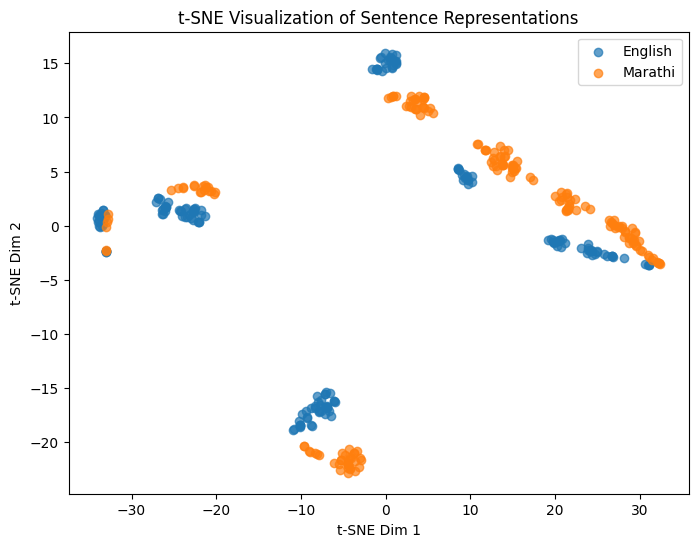

In [10]:
eng_layer_1=np.vstack(hs_df["eng_layer_8"].values)
mar_layer_1=np.vstack(hs_df["mar_layer_8"].values)
X_ = np.vstack((eng_layer_1, mar_layer_1))
labels = np.array([0] * eng_layer_1.shape[0] + [1] * mar_layer_1.shape[0])

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_embedded = tsne.fit_transform(X_)

plt.figure(figsize=(8, 6))
plt.scatter(X_embedded[labels == 0, 0], X_embedded[labels == 0, 1], label="English", alpha=0.7)
plt.scatter(X_embedded[labels == 1, 0], X_embedded[labels == 1, 1], label="Marathi", alpha=0.7)
plt.legend()
plt.title("t-SNE Visualization of Sentence Representations")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.show()


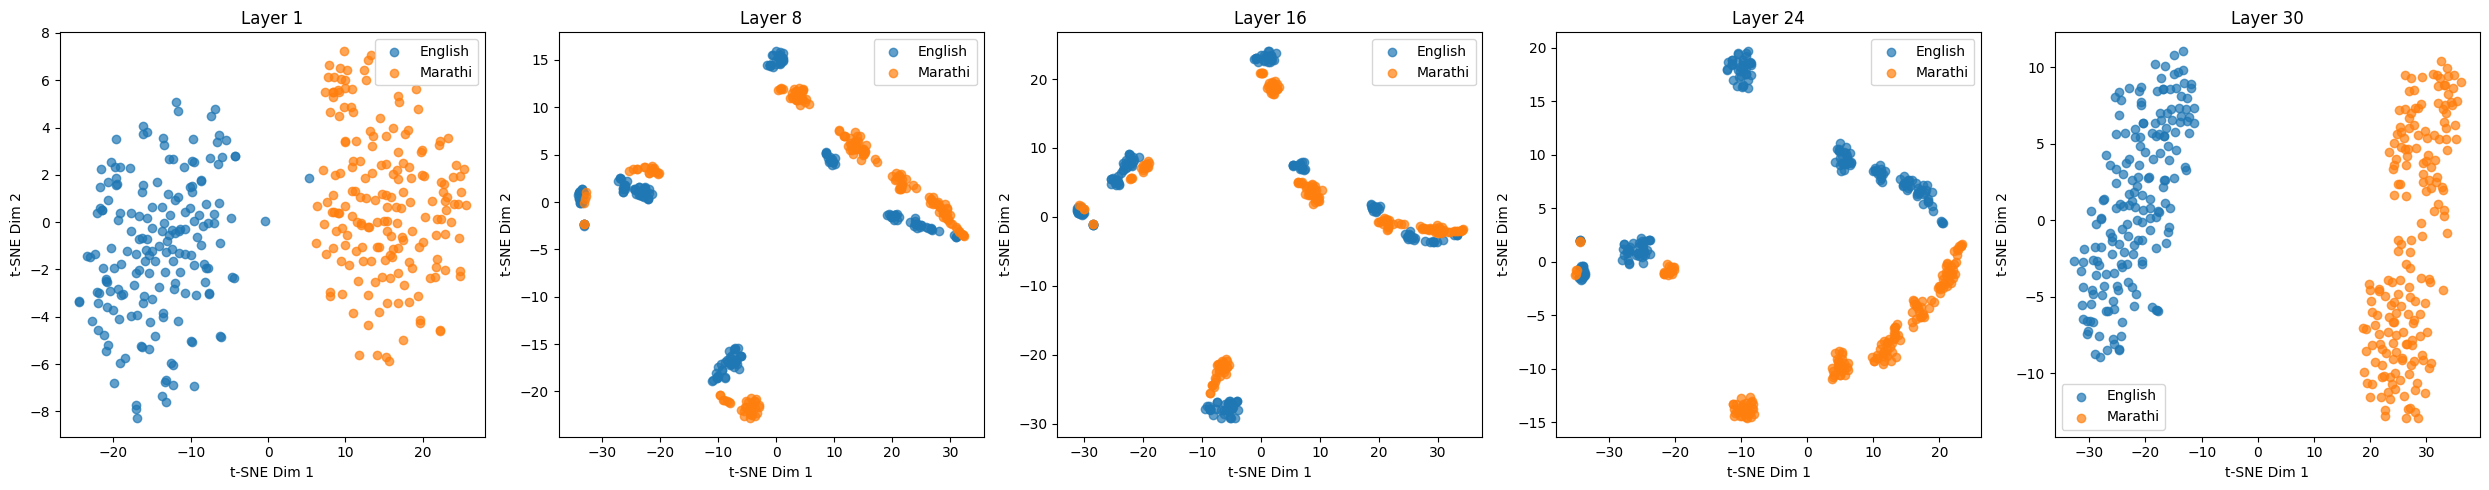

In [11]:
fig, axes = plt.subplots(1, len(layers), figsize=(5 * len(layers), 5))
for i, layer in enumerate(layers):
    eng_layer = np.vstack(hs_df[f"eng_layer_{layer}"].values)
    mar_layer = np.vstack(hs_df[f"mar_layer_{layer}"].values)

    X_ = np.vstack((eng_layer, mar_layer))
    labels = np.array([0] * eng_layer.shape[0] + [1] * mar_layer.shape[0])

    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    X_embedded = tsne.fit_transform(X_)

    ax = axes[i]
    ax.scatter(X_embedded[labels == 0, 0], X_embedded[labels == 0, 1], label="English", alpha=0.7)
    ax.scatter(X_embedded[labels == 1, 0], X_embedded[labels == 1, 1], label="Marathi", alpha=0.7)

    ax.legend()
    ax.set_title(f"Layer {layer}")
    ax.set_xlabel("t-SNE Dim 1")
    ax.set_ylabel("t-SNE Dim 2")

plt.tight_layout()
plt.savefig("tsne_layers_visualization.png", dpi=300)
plt.show()

### Fascinating visualization showing how the Bloom model processes English and Marathi languages across different layers (1, 8, 16, 24, and 30) using t-SNE dimensionality reduction

1. Layer 1 (Initial Layer):
- The representations of English and Marathi are clearly separated into two distinct clusters
- The distributions are relatively scattered and unstructured
- There's minimal interaction between the two language spaces

2. Layer 8:
- The representation becomes more structured with multiple distinct clusters for each language
- We start seeing some interesting geometric patterns forming
- The separation between languages is still maintained but with more complex clustering

3. Layer 16:
- The model appears to be learning deeper linguistic features as shown by the more organized structure
- At this layer, the representations of English and Marathi are somewhat mixed, indicating that the model has not yet fully distinguished between the two languages. There is some overlap in the t-SNE space.

4. Layer 24:
- English and Marathi tokens seem to follow similar patterns but remain separated
- By this layer, the representations start to show more separation. The clusters for English and Marathi are more distinct, suggesting that the model is beginning to differentiate between the languages more effectively.

5. Layer 30 (Final Layer):
- Exhibits the most organized and linear structure
- Clear separation between languages is maintained
- The representations appear to have aligned into parallel linear structures
- t the final layer, the separation between English and Marathi is quite clear. The clusters are well-defined, indicating that the model has learned to distinguish between the two languages effectively.

--------------------------------------------------------------------------------
Progressive Organization: From scattered points in Layer 1 to highly structured representations in Layer 30.   
Increasing Abstraction: Later layers show more organized and abstract representations compared to earlier layers


### SVCCA scores

In [29]:
X=np.vstack(hs_df[f"eng_layer_{layer}"].values)
Y=np.vstack(hs_df[f"mar_layer_{layer}"].values)
print(svd(X, full_matrices=False)[0].shape) # (180,180)
print(svd(X,full_matrices=False)[1].shape) # (180,)
print(svd(X,full_matrices=False)[2].shape) #((180, 4096))
U,S,V=svd(X,full_matrices=False)
print(np.dot(U,np.diag(S)).shape) # (180,180) (180,)


(180, 180)
(180,)
(180, 4096)
(180, 180)


In [32]:
import copy

def svcca(X,Y,threshold=0.95):
  X=np.copy(X)
  Y=np.copy(Y)
  X_mean = np.mean(X, axis=0)
  Y_mean = np.mean(Y, axis=0)
  X -= X_mean
  Y -= Y_mean
  U_x, S_X, Vt_x = svd(X, full_matrices=False)
  U_y, S_Y, Vt_y = svd(Y, full_matrices=False)
  cum_sx = np.cumsum(S_X) / np.sum(S_X)
  cum_sy = np.cumsum(S_Y) / np.sum(S_Y)
  d1 = np.searchsorted(cum_sx, threshold) + 1
  d2 = np.searchsorted(cum_sy, threshold) + 1

  X=np.dot(U_x[:,:d1],np.diag(S_X[:d1]))
  Y=np.dot(U_y[:,:d2],np.diag(S_Y[:d2]))
  n_comps = min(d1,d2)
  cca = CCA(n_components=n_comps)
  cca.fit(X, Y)
  X_c, Y_c = cca.transform(X, Y)
  correlations = [np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(n_comps)]
  return np.mean(correlations)

svcca_scores={}

for layer in layers:
  X=np.vstack(hs_df[f"eng_layer_{layer}"].values)
  Y=np.vstack(hs_df[f"mar_layer_{layer}"].values)
  print(min(X.shape[-1],Y.shape[-1]))
  X=copy.deepcopy(X)
  Y=copy.deepcopy(Y)
  svcca_scores[layer]=svcca(X,Y)

print(svcca_scores)





4096
4096
4096
4096
4096
{1: 0.9355158318774605, 8: 0.9167013053892599, 16: 0.9111715810019599, 24: 0.9201031960015875, 30: 0.8946971146345624}


SVCCA Score Analysis:  
1. Layer 1: 0.936 (Highest correlation)
- This high correlation is interesting because while the t-SNE plot shows clear separation, the underlying representational spaces are highly similar
- Suggests that at the early stage, the model maintains similar basic feature detection mechanisms for both languages
- The high SVCCA score in the first layer indicates that the initial representations of English and Marathi are very similar. This is expected because early layers typically capture general, language-agnostic features such as basic syntactic structures and common tokens.

2. Layer 8: 0.917
- The score decreases slightly, suggesting that the model starts to differentiate between the languages as it processes more complex features. However, the representations are still quite similar, indicating that the model is still capturing a lot of shared information.
- Corresponds to the emergence of more complex clustering in the t-SNE visualization


3. Layer 16: 0.911 (Local minimum)
he further decrease in the score shows that the model continues to differentiate between English and Marathi. This aligns with t-SNE visualization, where Layer 16 shows some separation but still has overlapping clusters.



4. Layer 24: 0.920 (Slight increase)
- Interestingly, the score increases slightly compared to Layer 16. This could indicate that the model is refining its representations, capturing more nuanced language-specific features while still maintaining some level of similarity. This might be due to the model learning higher-level syntactic and semantic structures that are somewhat shared between the languages.
- Suggests the model has found parallel linguistic structures between languages
- The curved manifold structure might represent similar linguistic phenomena in both languages

5. Layer 30: 0.895 (Lowest correlation)
- Final divergence in representations
- The parallel linear structures in t-SNE align with this lower correlation

High initial similarity → gradual divergence → slight convergence → final specialization
- The general trend shows a decrease in SVCCA scores from Layer 1 to Layer 30, indicating that the model progressively differentiates between English and Marathi as it processes information through deeper layers. This is consistent with the expected behavior of deep neural networks, where early layers capture general features and deeper layers capture more specific, task-relevant features
- This pattern suggests a sophisticated learning process where the model first understands common linguistic features before developing language-specific processing
- Early layers (1-8): Focus on shared linguistic features (high SVCCA scores)
- Middle layers (16): Development of language-specific processing
- Later layers (24-30): Balance between parallel structures and language specialization
- The high initial correlation suggests shared low-level feature detection
- The gradual decrease in correlation aligns with hierarchical feature learning
- The final layer's lower correlation supports effective language-specific task performance
- The consistently high SVCCA scores (all above 0.89) indicate strong cross-lingual alignment
- This suggests effective transfer learning potential between English and Marathi


These findings support the paper's investigation of multilingual NMT representations and suggest that:

- The model develops robust shared representations across languages
- It maintains a balance between shared and language-specific features
- The representation similarity pattern follows a meaningful progression through the network
- The architecture effectively handles multiple languages while preserving language-specific characteristics

